# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [42]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


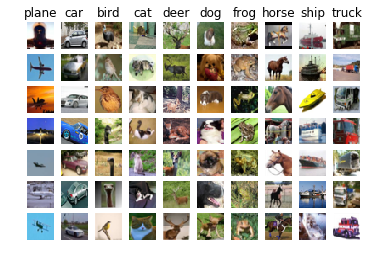

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


In [43]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

[ 1.18329437e-13 -4.63871300e-14 -3.80850906e-15 -4.01137627e-13
 -1.58515994e-13 -5.21631174e-14  4.76085674e-13  2.89594018e-14
 -1.12851587e-14  2.68177970e-13]


ValueError: cannot reshape array of size 3073 into shape (32,32,3)

<Figure size 288x288 with 0 Axes>

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

# toby: esse, we appended one [1] to the end of each row: 
# e.g. [23, 21, 44, 53] ==> [23, 21, 44, 53, 1]
# ??? hum...but why this works???

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [9]:
X_train[:,0]

array([ -71.64189796,   23.35810204,  124.35810204, ...,  -69.64189796,
       -120.64189796,   44.35810204])

In [10]:
X_train[:,1]

array([ -73.98173469,   41.01826531,  119.01826531, ...,  -62.98173469,
       -131.98173469,   57.01826531])

In [11]:
X_train

array([[ -71.64189796,  -73.98173469,  -69.47391837, ...,  -33.86195918,
         -42.39957143,    1.        ],
       [  23.35810204,   41.01826531,   54.52608163, ...,    7.13804082,
          29.60042857,    1.        ],
       [ 124.35810204,  119.01826531,  122.52608163, ...,  -39.86195918,
         -30.39957143,    1.        ],
       ...,
       [ -69.64189796,  -62.98173469,  -56.47391837, ...,   34.13804082,
           2.60042857,    1.        ],
       [-120.64189796, -131.98173469, -118.47391837, ...,   48.13804082,
          90.60042857,    1.        ],
       [  44.35810204,   57.01826531,   96.52608163, ...,  -47.86195918,
         -24.39957143,    1.        ]])

In [12]:
np.ones((X_train.shape[0], 1))

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [211]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive #<- usually doesn't work
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 



In [14]:
print(W[:,2].shape)  # return the second col
print(W[2,:].shape)  # return the second row
print(W.shape)

(3073,)
(10,)
(3073, 10)


In [227]:
X_train[1,:]
# W[:,1]

array([23.35810204, 41.01826531, 54.52608163, ...,  7.13804082,
       29.60042857,  1.        ])

In [15]:
X_train[2].shape

(3073,)

In [17]:
# print(y_train[0])
# scores[y_train[0]]

In [55]:
# # so we import the svm_loss_naive mannually
# import numpy as np
# from random import shuffle
# from past.builtins import xrange

# def svm_loss_naive(W, X, y, reg):
#     """
#     Structured SVM loss function, naive implementation (with loops).

#     Inputs have dimension D, there are C classes, and we operate on minibatches
#     of N examples.

#     Inputs:
#     - W: A numpy array of shape (D, C) containing weights.
#     - X: A numpy array of shape (N, D) containing a minibatch of data.
#     - y: A numpy array of shape (N,) containing training labels; y[i] = c means
#     that X[i] has label c, where 0 <= c < C.
#     - reg: (float) regularization strength

#     Returns a tuple of:
#     - loss as single float
#     - gradient with respect to weights W; an array of same shape as W
#     """
#     dW = np.zeros(W.shape) # initialize the gradient as zero

#     # compute the loss and the gradient
#     num_classes = W.shape[1]
#     num_train = X.shape[0]
#     loss = 0.0
    
#     for i in xrange(num_train):
#         scores = X[i].dot(W)
#         correct_class_score = scores[y[i]]
#         count = 0
#         for j in xrange(num_classes):
#             if j == y[i]:
#                 continue            
#             margin = scores[j] - correct_class_score + 1 # notice that the 1 here comes from delta.
#             # if margin exceeds the thresdhold, add it into loss. and  add to the dW.
#             if margin > 0:
#                 count += 1
#                 loss += margin
#                 dW[:,j] += X[i]
#         dW[:,y[i]] -= X[i,:] * count
#     # Right now the loss is a sum over all training examples, but we want it
#     # to be an average instead so we divide by num_train.
#     loss /= num_train
#     dW /= num_train
#     # Add regularization to the loss.
#     loss += reg * np.sum(W * W)
#     dW += 2 * reg * W
#     return loss, dW


In [56]:
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.586447


In [57]:
grad

array([[ 8.01420412e+00, -1.43935810e+01,  7.76287735e+00, ...,
        -1.55340537e+01, -8.50983706e+00, -2.29769991e+01],
       [-8.39427408e+00, -2.65218265e+00,  1.05911051e+01, ...,
        -1.61210229e+01, -2.22483380e+01, -2.75947033e+01],
       [-3.28251031e+01,  8.14739185e-01,  2.01734339e+01, ...,
        -1.30134606e+01, -4.26913384e+01, -3.63338601e+01],
       ...,
       [-9.22630155e+00, -2.99138041e+00, -1.36533061e-01, ...,
        -1.32357303e+01,  2.99683308e+01, -1.63084300e+01],
       [-3.11465003e+01, -6.72600428e+00,  6.11207286e+00, ...,
         7.51037600e+00,  9.86514514e+00, -2.12108634e+01],
       [-2.34000001e-01, -1.00000012e-02,  1.69999999e-01, ...,
        -5.60000002e-02, -1.28000001e-01, -1.48000000e-01]])

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [212]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -4.349339 analytic: -4.349339, relative error: 1.765436e-10
numerical: -3.734923 analytic: -3.734923, relative error: 7.946008e-11
numerical: -21.016115 analytic: -21.016115, relative error: 7.371384e-12
numerical: -6.264727 analytic: -6.264727, relative error: 2.000537e-11
numerical: 31.270100 analytic: 31.270100, relative error: 1.441759e-13
numerical: 11.005073 analytic: 11.005073, relative error: 3.127755e-11
numerical: 0.269193 analytic: 0.269193, relative error: 6.695893e-10
numerical: -0.119786 analytic: -0.119786, relative error: 3.479623e-09
numerical: -37.134393 analytic: -37.134393, relative error: 7.292965e-12
numerical: 6.788707 analytic: 6.788707, relative error: 1.564048e-11
numerical: -7.380555 analytic: -7.380555, relative error: 4.259879e-11
numerical: -25.035149 analytic: -25.035149, relative error: 1.004872e-11
numerical: -15.162184 analytic: -15.162184, relative error: 2.537979e-11
numerical: -37.415280 analytic: -37.415280, relative error: 1.502260e-12


### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*
1. Yes, it is possible that once in a while a dimension in the grad-check doesn't match.  
2. This iscrepancy is cauesed by the non-differentiability at some locations of the SVM loss function.  
3. Given the fact that SVM loss is convex, I don't think we need to worry about that.  
4. For example, at the boundary point of the loss function, it will not be differentiable, as a reuslt, the number from analytic calculation will be off a little.  

In [81]:
X = X_train
y = y_train
print(X.shape)
print(W.shape)
print(y_train.shape)
print(len(np.arange(X.shape[0])))

(49000, 3073)
(3073, 10)
(49000,)
49000


In [180]:
y

array([6, 9, 9, ..., 4, 9, 3])

In [179]:
num_train = X.shape[0]
scores = X.dot(W)
print(scores.shape)
correct_class_scores = scores[range(num_train), list(y)].reshape(-1,1) #(N, 1)
print(correct_class_scores.shape)

(49000, 10)
(49000, 1)


In [103]:
print(score[0])
print(correct_score[0])
print(y[:5])

[-0.72584067  0.30856037 -0.13429471 -0.17908701 -0.07406083 -0.35939892
  0.29717128 -0.25868203  0.42803262  0.17338938]
0.2971712848940469
[6 9 9 4 1]


In [181]:
margins = np.maximum(0, scores - correct_class_scores +1)
margins

array([[0.        , 1.01138909, 0.56853401, ..., 0.44414668, 1.13086133,
        0.8762181 ],
       [1.70040847, 1.35734664, 1.26901281, ..., 1.91655964, 2.30492942,
        1.        ],
       [2.40868732, 0.73826573, 1.42058534, ..., 0.70739582, 0.59745249,
        1.        ],
       ...,
       [0.47722631, 0.97499423, 1.21045828, ..., 1.16071556, 1.08997987,
        1.22474734],
       [0.        , 1.49926458, 1.17924511, ..., 1.06368056, 1.13092977,
        1.        ],
       [1.52029511, 1.18045806, 1.37979017, ..., 0.83369823, 1.27275557,
        0.85683026]])

In [183]:
margin = (score.T - correct_score.T+1).T
margin[np.arange(X.shape[0]),y] = 0
margin

array([[-0.02301195,  1.01138909,  0.56853401, ...,  0.44414668,
         1.13086133,  0.8762181 ],
       [ 1.70040847,  1.35734664,  1.26901281, ...,  1.91655964,
         2.30492942,  0.        ],
       [ 2.40868732,  0.73826573,  1.42058534, ...,  0.70739582,
         0.59745249,  0.        ],
       ...,
       [ 0.47722631,  0.97499423,  1.21045828, ...,  1.16071556,
         1.08997987,  1.22474734],
       [-0.20900573,  1.49926458,  1.17924511, ...,  1.06368056,
         1.13092977,  0.        ],
       [ 1.52029511,  1.18045806,  1.37979017, ...,  0.83369823,
         1.27275557,  0.85683026]])

In [192]:
margin = (score.T - correct_score.T+1).T
print(margin.shape)
print(margin[0])
margin = np.maximum(margin, 0)
margin[np.arange(X.shape[0]),y] = 0
print(margin.shape)
print("margin 0",margin[0])
loss = np.sum(margin)
print(loss.shape)

loss /= X.shape[0]
loss

(49000, 10)
[-0.02301195  1.01138909  0.56853401  0.52374171  0.62876788  0.3434298
  1.          0.44414668  1.13086133  0.8762181 ]
(49000, 10)
margin 0 [0.         1.01138909 0.56853401 0.52374171 0.62876788 0.3434298
 0.         0.44414668 1.13086133 0.8762181 ]
()


8.74875484027955

In [193]:
margin

array([[0.        , 1.01138909, 0.56853401, ..., 0.44414668, 1.13086133,
        0.8762181 ],
       [1.70040847, 1.35734664, 1.26901281, ..., 1.91655964, 2.30492942,
        0.        ],
       [2.40868732, 0.73826573, 1.42058534, ..., 0.70739582, 0.59745249,
        0.        ],
       ...,
       [0.47722631, 0.97499423, 1.21045828, ..., 1.16071556, 1.08997987,
        1.22474734],
       [0.        , 1.49926458, 1.17924511, ..., 1.06368056, 1.13092977,
        0.        ],
       [1.52029511, 1.18045806, 1.37979017, ..., 0.83369823, 1.27275557,
        0.85683026]])

In [87]:
print(type(score),type(correct_score))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [147]:
print(X.shape)
dW = np.sum(X,axis = 0).T
print(dW.shape)
dW

(49000, 3073)
(3073,)


array([ 5.79814241e-09, -2.27296937e-09, -1.86616944e-10, ...,
       -1.20154766e-08, -1.33135529e-08,  4.90000000e+04])

In [188]:
coeff_mat = np.zeros((num_train, num_classes))
coeff_mat[margins > 0] = 1
coeff_mat[range(num_train), list(y)] = 0
coeff_mat

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [189]:
np.sum(coeff_mat, axis=1)

array([8., 9., 9., ..., 9., 8., 9.])

In [190]:
coeff_mat[range(num_train), list(y)] = -np.sum(coeff_mat, axis=1)
print(coeff_mat.shape)
coeff_mat

(49000, 10)


array([[ 0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -9.],
       [ 1.,  1.,  1., ...,  1.,  1., -9.],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 0.,  1.,  1., ...,  1.,  1., -8.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [194]:
select_wrong = np.zeros(margin.shape)
select_wrong[margin > 0] = 1

select_correct = np.zeros(margin.shape)
select_correct[margin == 0] = 1


dW = (select_wrong.T.dot(X)).T
dW -= (select_correct.T.dot(X)).T
print(dW.shape)

(3073, 10)


In [148]:
dW = np.tile(dW, (W.shape[1],1)).T
print(dW.shape)

(3073, 10)


In [141]:
y_spot = np.zeros(margin.shape)
y_spot[margin == 0]=1
print(y_spot.shape)
y_score = (X.T).dot(y_spot)
print(y_score.shape)

(49000, 10)
(3073, 10)


In [145]:
print(y_spot.sum(axis=1))
y_score
# X

[1. 1. 1. ... 1. 1. 1.]


array([[ 70337.35532653,  30015.89606122, -27305.77985714, ...,
         20426.19328571,  76451.04467347, 178517.9094898 ],
       [123968.73744898,  11113.15295918, -24056.11642857, ...,
         25918.37214286, 130900.26255102, 201687.40867347],
       [225020.63906122,  17051.80444898, -83384.15228571, ...,
         23863.11742857, 226061.96093878, 255376.16959184],
       ...,
       [ 50303.19453061,  27014.77722449,    468.29885714, ...,
         45065.43371429, -77943.39453061,  48493.70979592],
       [115171.90557143,  59753.69185714, -37096.291     , ...,
        -28641.103     ,  17594.29442857,  68387.09785714],
       [  4913.        ,   4881.        ,   4921.        , ...,
          4893.        ,   4887.        ,   4895.        ]])

In [198]:
# # Next implement the function svm_loss_vectorized; for now only compute the loss;
# # we will implement the gradient in a moment.
# def svm_loss_vectorized_bad(W, X, y, reg):
#     """
#     Structured SVM loss function, vectorized implementation.

#     Inputs and outputs are the same as svm_loss_naive.
#     """
#     loss = 0.0
#     dW = np.zeros(W.shape) # initialize the gradient as zero

#     #############################################################################
#     # TODO:                                                                     #
#     # Implement a vectorized version of the structured SVM loss, storing the    #
#     # result in loss.                                                           #
#     #############################################################################
#     score = X.dot(W)
#     correct_score = score[np.arange(X.shape[0]), y]
#     margin = (score.T - correct_score.T+1).T
#     margin = np.maximum(margin, 0)
#     margin[np.arange(X.shape[0]),y] = 0
#     loss = np.sum(margin)
#     loss /= X.shape[0]
#     loss += reg *np.sum(W**2)
#     #############################################################################
#     #                             END OF YOUR CODE                              #
#     #############################################################################


#     #############################################################################
#     # TODO:                                                                     #
#     # Implement a vectorized version of the gradient for the structured SVM     #
#     # loss, storing the result in dW.                                           #
#     #                                                                           #
#     # Hint: Instead of computing the gradient from scratch, it may be easier    #
#     # to reuse some of the intermediate values that you used to compute the     #
#     # loss.                                                                     #
#     #############################################################################
#     select_wrong = np.zeros(margin.shape)
#     select_wrong[margin > 0] = 1
    
#     select_correct = np.zeros(margin.shape)
#     select_correct[margin == 0] = 1 
    
#     dW = (select_wrong.T.dot(X)).T
    
#     #dW here is wrong. it actually depends on the result of np.max
#     # to tell how many times you shall subtract correct X[i]
#     dW -= (select_correct.T.dot(X)).T
#     dW /= X.shape[0]
#     dW += 2 * reg * W
#     #############################################################################
#     #                             END OF YOUR CODE                              #
#     #############################################################################

#     return loss, dW

In [200]:
# def svm_loss_vectorized(W, X, y, reg):
#     """
#     Structured SVM loss function, vectorized implementation.
#     Inputs and outputs are the same as svm_loss_naive.
#     """
#     loss = 0.0
#     dW = np.zeros(W.shape) # initialize the gradient as zero

#     #############################################################################
#     # TODO:                                                                     #
#     # Implement a vectorized version of the structured SVM loss, storing the    #
#     # result in loss.                                                           #
#     #############################################################################
#     num_train = X.shape[0]
#     num_classes = W.shape[1]
#     scores = X.dot(W)
#     correct_class_scores = scores[range(num_train), list(y)].reshape(-1,1) #(N, 1)
#     margins = np.maximum(0, scores - correct_class_scores +1)
#     margins[range(num_train), list(y)] = 0
#     loss = np.sum(margins) / num_train + 0.5 * reg * np.sum(W * W)
#     #pass
#     #############################################################################
#     #                             END OF YOUR CODE                              #
#     #############################################################################


#     #############################################################################
#     # TODO:                                                                     #
#     # Implement a vectorized version of the gradient for the structured SVM     #
#     # loss, storing the result in dW.                                           #
#     #                                                                           #
#     # Hint: Instead of computing the gradient from scratch, it may be easier    #
#     # to reuse some of the intermediate values that you used to compute the     #
#     # loss.                                                                     #
#     #############################################################################
#     coeff_mat = np.zeros((num_train, num_classes))
#     coeff_mat[margins > 0] = 1
#     coeff_mat[range(num_train), list(y)] = 0
#     coeff_mat[range(num_train), list(y)] = -np.sum(coeff_mat, axis=1)

#     dW = (X.T).dot(coeff_mat)
#     dW = dW/num_train + reg*W
#     #pass
#     #############################################################################
#     #                             END OF YOUR CODE                              #
#     #############################################################################

#     return loss, dW

In [213]:
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

# from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.711545e+00 computed in 0.094696s
Vectorized loss: 8.711545e+00 computed in 0.003090s
difference: 0.000000


In [214]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.084683s
Vectorized loss and gradient: computed in 0.006313s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [236]:
t = np.random.choice(range(20),3)
X[t]
X[1].argmax(axis=0)

1565

In [232]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM

svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 405.015190
iteration 100 / 1500: loss 239.018112
iteration 200 / 1500: loss 145.724301
iteration 300 / 1500: loss 89.323965
iteration 400 / 1500: loss 55.734922
iteration 500 / 1500: loss 35.999566
iteration 600 / 1500: loss 23.515515
iteration 700 / 1500: loss 16.144571
iteration 800 / 1500: loss 11.544245
iteration 900 / 1500: loss 8.788841
iteration 1000 / 1500: loss 7.225437
iteration 1100 / 1500: loss 6.984859
iteration 1200 / 1500: loss 6.599823
iteration 1300 / 1500: loss 5.230866
iteration 1400 / 1500: loss 4.752449
That took 13.787723s


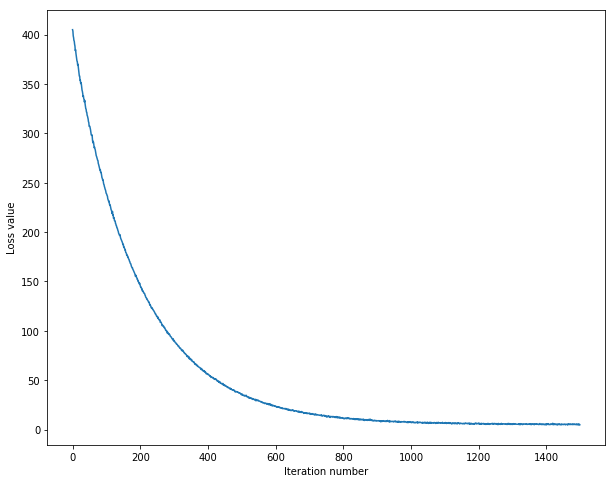

In [233]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [237]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.377776
validation accuracy: 0.391000


In [249]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 2e-7, 5e-7, 1e-6, 1e-5]
regularization_strengths = [1e4, 2e4, 2.5e4, 5e4, 1e5, 5e5, 1e6]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# pass
for l in learning_rates:
    for r in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, l, r,num_iters=2000, verbose=True)
        
        y_train_pred = svm.predict(X_train)
        train_score = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
        
        y_val_pred = svm.predict(X_val)
        val_score = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

        results[(l,r)] = (train_score, val_score)
        if val_score > best_val:
            best_val = val_score
            best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    


iteration 0 / 2000: loss 173.428093
iteration 100 / 2000: loss 134.714452
iteration 200 / 2000: loss 110.115152
iteration 300 / 2000: loss 90.066265
iteration 400 / 2000: loss 73.876454
iteration 500 / 2000: loss 60.482618
iteration 600 / 2000: loss 50.800615
iteration 700 / 2000: loss 41.880051
iteration 800 / 2000: loss 35.052687
iteration 900 / 2000: loss 29.092143
iteration 1000 / 2000: loss 24.275318
iteration 1100 / 2000: loss 21.447700
iteration 1200 / 2000: loss 18.096950
iteration 1300 / 2000: loss 15.650393
iteration 1400 / 2000: loss 13.326705
iteration 1500 / 2000: loss 11.545339
iteration 1600 / 2000: loss 10.699686
iteration 1700 / 2000: loss 9.606977
iteration 1800 / 2000: loss 8.574872
iteration 1900 / 2000: loss 7.665062
training accuracy: 0.387939
validation accuracy: 0.383000
iteration 0 / 2000: loss 335.614135
iteration 100 / 2000: loss 214.626649
iteration 200 / 2000: loss 143.909358
iteration 300 / 2000: loss 96.465645
iteration 400 / 2000: loss 66.225294
iteratio

iteration 700 / 2000: loss 5.338279
iteration 800 / 2000: loss 5.355407
iteration 900 / 2000: loss 5.459569
iteration 1000 / 2000: loss 5.421979
iteration 1100 / 2000: loss 5.308624
iteration 1200 / 2000: loss 5.680355
iteration 1300 / 2000: loss 5.444097
iteration 1400 / 2000: loss 5.481690
iteration 1500 / 2000: loss 5.825051
iteration 1600 / 2000: loss 6.042173
iteration 1700 / 2000: loss 5.447851
iteration 1800 / 2000: loss 5.312272
iteration 1900 / 2000: loss 5.530743
training accuracy: 0.367224
validation accuracy: 0.380000
iteration 0 / 2000: loss 1551.369323
iteration 100 / 2000: loss 32.495746
iteration 200 / 2000: loss 6.240996
iteration 300 / 2000: loss 5.692084
iteration 400 / 2000: loss 5.822154
iteration 500 / 2000: loss 5.604210
iteration 600 / 2000: loss 5.673141
iteration 700 / 2000: loss 5.475291
iteration 800 / 2000: loss 6.090763
iteration 900 / 2000: loss 5.449571
iteration 1000 / 2000: loss 6.069441
iteration 1100 / 2000: loss 5.516834
iteration 1200 / 2000: loss 

iteration 1600 / 2000: loss 7.876620
iteration 1700 / 2000: loss 8.454546
iteration 1800 / 2000: loss 8.703243
iteration 1900 / 2000: loss 8.422157
training accuracy: 0.248980
validation accuracy: 0.257000
iteration 0 / 2000: loss 175.674331
iteration 100 / 2000: loss 25.935226
iteration 200 / 2000: loss 7.896449
iteration 300 / 2000: loss 6.611227
iteration 400 / 2000: loss 6.168083
iteration 500 / 2000: loss 6.364075
iteration 600 / 2000: loss 6.161826
iteration 700 / 2000: loss 6.348679
iteration 800 / 2000: loss 5.548380
iteration 900 / 2000: loss 5.201156
iteration 1000 / 2000: loss 5.639179
iteration 1100 / 2000: loss 5.732026
iteration 1200 / 2000: loss 6.809702
iteration 1300 / 2000: loss 5.682302
iteration 1400 / 2000: loss 5.834833
iteration 1500 / 2000: loss 5.750497
iteration 1600 / 2000: loss 5.937082
iteration 1700 / 2000: loss 6.387171
iteration 1800 / 2000: loss 5.955047
iteration 1900 / 2000: loss 5.932539
training accuracy: 0.311857
validation accuracy: 0.318000
itera

iteration 100 / 2000: loss 69.759683
iteration 200 / 2000: loss 41.091544
iteration 300 / 2000: loss 38.476592
iteration 400 / 2000: loss 74.925048
iteration 500 / 2000: loss 41.350612
iteration 600 / 2000: loss 66.739853
iteration 700 / 2000: loss 63.426724
iteration 800 / 2000: loss 56.215893
iteration 900 / 2000: loss 101.013362
iteration 1000 / 2000: loss 64.293915
iteration 1100 / 2000: loss 68.890530
iteration 1200 / 2000: loss 48.478237
iteration 1300 / 2000: loss 53.285376
iteration 1400 / 2000: loss 48.252219
iteration 1500 / 2000: loss 59.584815
iteration 1600 / 2000: loss 66.057435
iteration 1700 / 2000: loss 74.898382
iteration 1800 / 2000: loss 54.191486
iteration 1900 / 2000: loss 52.428680
training accuracy: 0.189408
validation accuracy: 0.194000
iteration 0 / 2000: loss 1551.354282
iteration 100 / 2000: loss 120.577530
iteration 200 / 2000: loss 106.768536
iteration 300 / 2000: loss 107.788492
iteration 400 / 2000: loss 105.172841
iteration 500 / 2000: loss 125.162660
i

/Users/toby/Documents/edX/Stanford_231n/CS231n/assignment1/cs231n/classifiers/linear_svm.py:88: RuntimeWarning: overflow encountered in double_scalars
  loss = np.sum(margins) / num_train + 0.5 * reg * np.sum(W*W)
/Users/toby/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Users/toby/Documents/edX/Stanford_231n/CS231n/assignment1/cs231n/classifiers/linear_svm.py:88: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(margins) / num_train + 0.5 * reg * np.sum(W*W)


iteration 300 / 2000: loss inf
iteration 400 / 2000: loss inf
iteration 500 / 2000: loss inf


/Users/toby/Documents/edX/Stanford_231n/CS231n/assignment1/cs231n/classifiers/linear_svm.py:110: RuntimeWarning: overflow encountered in multiply
  dW = dW/num_train + reg*W
/Users/toby/Documents/edX/Stanford_231n/CS231n/assignment1/cs231n/classifiers/linear_svm.py:104: RuntimeWarning: invalid value encountered in greater
  coeff_mat[margins > 0] = 1
/Users/toby/Documents/edX/Stanford_231n/CS231n/assignment1/cs231n/classifiers/linear_classifier.py:72: RuntimeWarning: invalid value encountered in add
  self.W += -learning_rate * grad


iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 2000: loss 15236.736482
iteration 100 / 2000: loss 1075280902060500432062303269549644474227074449553868400288129728398734235488019889989645560666079710407542998350817807275688327097791293854142461515687073230612650985656884499317754031064469209088.000000
iteration 200 / 2000: loss inf
iteration 300 / 2000: loss inf
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 90

In [250]:
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.387939 val accuracy: 0.383000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.377000 val accuracy: 0.383000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.381857 val accuracy: 0.374000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.367367 val accuracy: 0.376000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.363857 val accuracy: 0.387000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.321367 val accuracy: 0.339000
lr 1.000000e-07 reg 1.000000e+06 train accuracy: 0.303796 val accuracy: 0.318000
lr 2.000000e-07 reg 1.000000e+04 train accuracy: 0.388102 val accuracy: 0.393000
lr 2.000000e-07 reg 2.000000e+04 train accuracy: 0.373122 val accuracy: 0.390000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.367694 val accuracy: 0.376000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.367224 val accuracy: 0.380000
lr 2.000000e-07 reg 1.000000e+05 train accuracy: 0.338041 val accuracy: 0.349000
lr 2.000000e-07 reg 5.000000

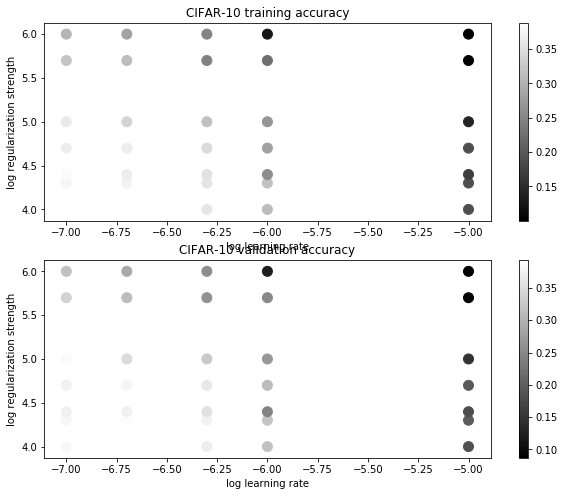

In [262]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

#colorbar https://stackoverflow.com/questions/3279560/reverse-colormap-in-matplotlib

In [252]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.366000


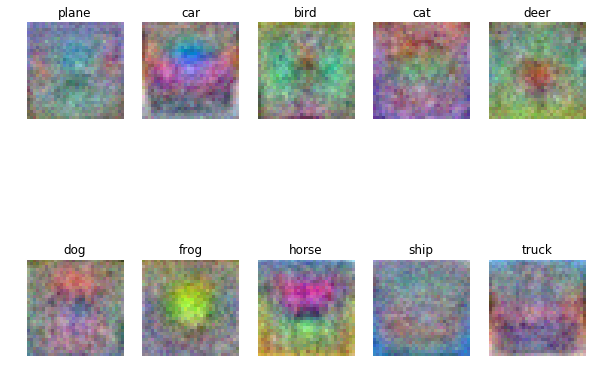

In [253]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*